# Building and post-processing problem set 1 with FloPy

## PS1A

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500 ft will be specified for `delr` and `delc`. The top (`TOP`) of the model should be set to 400 ft and the bottom of the three layers (`BOTM`) should be set to 220 ft, 200 ft, and 0 ft, respectively. The model has one steady-state stress period. 

MODFLOW does not require that input data be provided in specific units (for example, SI units) instead it only requires that consistent units be used. As a result all input data should be specified with a length unit of feet and a time unit of days.

In [1]:
import pathlib as pl
import platform

import flopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Before creating any of the MODFLOW 6 FloPy objects you should define the simulation workspace (`ws`) where the model files are and the simulation name (`name`).

In [2]:
ws = pl.Path("PS1a")
name = "ps1"

## Build the model

Create a simulation object, a temporal discretization object, and a iterative model solution object using `flopy.mf6.MFSimulation()`, `flopy.mf6.ModflowTdis()`, and `flopy.mf6.ModflowIms()`, respectively. Set the `sim_name` to `name` and `sim_ws` to `ws` in the simulation object. Use default values for all temporal discretization and iterative model solution variables. Make sure to include the simulation object (`sim`) as the first variable in the temporal discretization and iterative model solution objects. 

**NOTE:** Variables with default values (for example, `time_units=None` in `flopy.mf6.ModflowTdis()`).

In [3]:
# create simulation (sim = flopy.mf6.MFSimulation())
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)

# create tdis package (tdis = flopy.mf6.ModflowTdis(sim))
tdis = flopy.mf6.ModflowTdis(sim, perioddata=((365.0, 1, 1.0),))

# create iterative model solution (ims = flopy.mf6.ModflowIms(sim))
ims = flopy.mf6.ModflowIms(sim)

Create the groundwater flow model object (`gwf`) using `flopy.mf6.ModflowGwf()`. Make sure to include the simulation object (`sim`) as the first variable in the groundwater flow model object and set `modelname` to `name`. Use `Shift-Tab` to see the optional variables that can be specified.

In [4]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True, print_flows=True)

Create the discretization package using `flopy.mf6.ModflowGwfdis()`. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `DIS` package (`flopy.mf6.ModflowGwfdis()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-dis.html).

FloPy can accomodate all of the options for specifying array data for a model. `CONSTANT` values for a variable can be specified by using a `float` or `int` python variable (as is done below for `DELR`, `DELC`, and `TOP`). `LAYERED` data can be specified by using a list or `CONSTANT` values for each layer (as is done below for `BOTM` data) or a list of numpy arrays or lists. Three-Dimensional data can be specified using a three-dimensional numpy array (with a shape of `(nlay, nrow, ncol)`) for this example. More information on how to specify array data can be found in the [FloPy ReadTheDocs](https://flopy.readthedocs.io/en/latest/Notebooks/mf6_data_tutorial07.html#MODFLOW-6:-Working-with-MODFLOW-Grid-Array-Data). 

In [5]:
# dis data
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400
botm = [220, 200, 0]

In [6]:
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm)

### Create the initial conditions (IC) package

Create the initial conditions package (`IC`) using `flopy.mf6.ModflowGwfic()` and set the initial head (`strt`) to 320. Default values can be used for the rest of the initial conditions package input. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `IC` package (`flopy.mf6.ModflowGwfic()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-ic.html).

In [7]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=420)

### Create the node property flow (NPF) package

The hydraulic properties for the model are defined in the image above and are specified in the node property flow package (`NPF`) using `flopy.mf6.ModflowGwfnpf()`. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so `icelltype` should be `[1, 0, 0]`. The horizontal (`k`) and vertical (`k33`) conductivity should also be assigned as python lists (`[,,]`) and the values shown in the image above. The variable `save_specific_discharge` should be set to `True` so that specific discharge data are saved to the cell-by-cell file and can be used to plot discharge. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `NPF` package (`flopy.mf6.ModflowGwfic()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-npf.html).

In [8]:
icelltype = [1, 0, 0]
k = [50, 0.01, 200]
k33 = [10, 0.01, 20]

In [9]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=icelltype, k=k, k33=k33)

## Create the river chd

The river is located in layer 1 and column 20 in every row in the model. The river stage stage is 320. Use the `flopy.mf6.ModflowGwfchd()` method to specify well data for the river package (`RIV`). Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `RIV` package (`flopy.mf6.ModflowGwfchd()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-chd.html).

An example of a `stress_period_data` tuple for the `CHD` package is

```python
# (layer, row, column, head)
(0, 0, 0, 320.)
```

**HINT**: list comprehension is an easy way to create a constant head cell in every row in column 20 of the model.

**NOTE:** Remember the `pname="river"` tip to prevent creating multiple versions of the river package if you rerun the cell.


In [10]:
riv_spd = [(0, i, ncol - 1, 320) for i in range(nrow)]

In [11]:
riv_spd

[(0, 0, 19, 320),
 (0, 1, 19, 320),
 (0, 2, 19, 320),
 (0, 3, 19, 320),
 (0, 4, 19, 320),
 (0, 5, 19, 320),
 (0, 6, 19, 320),
 (0, 7, 19, 320),
 (0, 8, 19, 320),
 (0, 9, 19, 320),
 (0, 10, 19, 320),
 (0, 11, 19, 320),
 (0, 12, 19, 320),
 (0, 13, 19, 320),
 (0, 14, 19, 320),
 (0, 15, 19, 320),
 (0, 16, 19, 320),
 (0, 17, 19, 320),
 (0, 18, 19, 320),
 (0, 19, 19, 320),
 (0, 20, 19, 320)]

In [12]:
riv_chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=riv_spd, pname="river")

## Create the canal chd

The canal is located in layer 1 and column 1 in every row in the model. The canal stage stage is 330. Use the `flopy.mf6.ModflowGwfchd()` method to specify well data for the river package (`RIV`). Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `RIV` package (`flopy.mf6.ModflowGwfchd()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-chd.html).

An example of a `stress_period_data` tuple for the `CHD` package is

```python
# (layer, row, column, head)
(0, 0, 0, 330.)
```

**HINT**: list comprehension is an easy way to create a constant head cell in every row in column 1 of the model.

**NOTE:** Remember the `pname="canal"` tip to prevent creating multiple versions of the chd canal package if you rerun the cell.


In [13]:
canal_spd = [(0, i, 0, 330) for i in range(nrow)]

In [14]:
canal_spd

[(0, 0, 0, 330),
 (0, 1, 0, 330),
 (0, 2, 0, 330),
 (0, 3, 0, 330),
 (0, 4, 0, 330),
 (0, 5, 0, 330),
 (0, 6, 0, 330),
 (0, 7, 0, 330),
 (0, 8, 0, 330),
 (0, 9, 0, 330),
 (0, 10, 0, 330),
 (0, 11, 0, 330),
 (0, 12, 0, 330),
 (0, 13, 0, 330),
 (0, 14, 0, 330),
 (0, 15, 0, 330),
 (0, 16, 0, 330),
 (0, 17, 0, 330),
 (0, 18, 0, 330),
 (0, 19, 0, 330),
 (0, 20, 0, 330)]

In [15]:
canal_chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=canal_spd, pname="canal")

### Build output control

Define the output control package (`OC`) for the model using the `flopy.mf6.ModflowGwfoc()` method to `[('HEAD', 'ALL'), ('BUDGET', 'ALL')]` to save the head and flow for the model. Also the head (`head_filerecord`) and cell-by-cell flow (`budget_filerecord`) files should be set to `f"{name}.hds"` and `f"{name}.cbc"`, respectively. Use `Shift-Tab` to see the optional variables that can be specified. A description of the data required by the `OC` package (`flopy.mf6.ModflowGwfoc()`) can be found in the MODFLOW 6 [ReadTheDocs document](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-oc.html).

In [16]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    headprintrecord=["COLUMNS", 20, "WIDTH", 10, "DIGITS", 4, "FIXED"],
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL")],
)

### Write the model files and run the model

Write the MODFLOW 6 model files using `sim.write_simulation()`. Use `Shift-Tab` to see the optional variables that can be specified for `.write_simulation()`.

In [17]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ps1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package river...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 21 based on size of stress_period_data
    writing package canal...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...


Run the model using `sim.run_simulation()`, which will run the MODFLOW 6 executable installed in the Miniforge class environment (`pyclass`) and the MODFLOW 6 model files created with `.write_simulation()`. Use `Shift-Tab` to see the optional variables that can be specified for `.run_simulation()`.

In [18]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

## Post-process the results


### Exercise 1
Load the listing file to see the inflows and outflows

In [19]:
lst = gwf.output.list()

In [20]:
ds = lst.get_dataframes()[0]
ds

,CHD_IN,CHD2_IN,TOTAL_IN,CHD_OUT,CHD2_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1971-01-01,0.0,96951.539062,96951.539062,96949.4375,0.0,96949.4375,2.1017,0.0


Load the heads and face flows from the hds file. The head file can be loaded with the `gwf.output.head().get_data()` method. Name the heads data `hds`.

In [21]:
hds = gwf.output.head().get_data()

In [22]:
hds[0, 0, :]

array([330.        , 329.25942191, 328.59984434, 328.00817433,
       327.47268975, 326.98281118, 326.52890663, 326.10210529,
       325.69408801, 325.29689924, 324.90275428, 324.50383646,
       324.09208382, 323.65895973, 323.19519864, 322.6905155 ,
       322.13326603, 321.5100372 , 320.80514212, 320.        ])

In [23]:
hds[1, 0, :]

array([327.75069153, 327.37432502, 327.03235786, 326.71941741,
       326.43050819, 326.16112295, 325.90714429, 325.66476024,
       325.4303907 , 325.20060645, 324.97204314, 324.74131357,
       324.50491623, 324.25913563, 323.9999304 , 323.72280367,
       323.42264865, 323.0935688 , 322.72864819, 322.31985446])

### Canal flux

In [24]:
bmean = hds[0, 0, 0:2].mean() - botm[0]
bmean

np.float64(109.62971095314083)

In [25]:
C = k[0] * bmean * delc / delr
C

np.float64(5481.485547657041)

$Q = q * area = -K area * dh / dx$

In [26]:
k[0] * bmean * delc * ((hds[0, 0, 0] - hds[0, 0, 1]) / delr)

np.float64(4059.4681176284867)

In [27]:
Q = C * (hds[0, 0, 0] - hds[0, 0, 1])
Q

np.float64(4059.468117628487)

In [28]:
C12 = k33[1] * delr * delc / 10.
C12

250.0

In [29]:
Q12 = C12 * (hds[0, 0, 0] - hds[1, 0, 0])
Q12

np.float64(562.3271164797217)

In [30]:
21 * (Q + Q12)

np.float64(97057.6999162724)

### River flux

In [31]:
bmean = hds[0, 0, 18:20].mean() - botm[0]
bmean

np.float64(100.40257106145367)

In [32]:
C = k[0] * bmean * delc / delr
C

np.float64(5020.128553072684)

In [33]:
Q = C * (hds[0, 0, 18] - hds[0, 0, 19])
Q

np.float64(4041.9169604886997)

In [34]:
C12 = k33[1] * delr * delc / 10.
C12

250.0

In [35]:
Q12 = C12 * (hds[1, 0, -1] - hds[0, 0, -1])
Q12

np.float64(579.9636159970731)

In [36]:
21 * (Q + Q12)

np.float64(97059.49210620123)

### Exercise 2

Load the budget flows from the cbc file. The cell-by-cell file can be loaded with the `gwf.output.budget().get_data()` method. 

In [37]:
hds = gwf.output.head().get_data()

The unique records in the cell budget file can be determined using `.headers[["text", "imeth"]].drop_duplicates()`.

In [38]:
gwf.output.budget().headers[["text", "imeth"]].drop_duplicates()

,text,imeth
64,FLOW-JA-FACE,1
62064,DATA-SPDIS,6
112648,CHD,6


Retrieve the `'DATA-SPDIS'` data type from the cell-by-cell file. Name the specific discharge data `spd`.

Cell-by-cell data is returned as a list so access the data by using `spd = gwf.output.budget().get_data(text="DATA-SPDIS")[0]`.

In [39]:
spd = gwf.output.budget().get_data(text="DATA-SPDIS")[0]

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

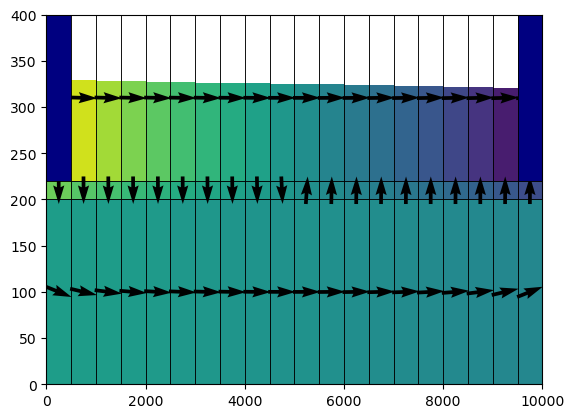

In [40]:
xs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 10})
cbv = xs.plot_array(hds, head=hds)
q = xs.plot_vector(spd["qx"], spd["qy"], spd["qz"], normalize=True)
xs.plot_bc("CHD")
xs.plot_bc("CHD")
xs.plot_grid(lw=0.5, color="black")

### Exercise 3

In [41]:
hd = hds[:, 0, 10] - hds[:, 0, 9]
hd

array([-0.39414495, -0.22856331, -0.06363609])

In [42]:
b = [hds[0, 0, 9:11].mean() - botm[0], botm[0] - botm[1], botm[1] - botm[2]]
b

[np.float64(105.09982675880622), 20, 200]

In [43]:
Q = np.array(k) * b * delc * hd / delr
Q

array([-2.07122832e+03, -4.57126627e-02, -2.54544360e+03])

In [44]:
Q * 21

array([-4.34957947e+04, -9.59965917e-01, -5.34543156e+04])

### Exercise 4

In [45]:
C23 = k33[1] * delr * delc / 10.

In [46]:
hd = hds[1, 0, :] - hds[2, 0, :]
hd

array([ 2.24008889,  1.87765323,  1.56129441,  1.28367192,  1.03806376,
        0.8184352 ,  0.61930294,  0.43561658,  0.26265366,  0.09590926,
       -0.06901796, -0.2365409 , -0.41120294, -0.59780582, -0.8015514 ,
       -1.02820364, -1.28427886, -1.57726614, -1.91590348, -2.31032915])

In [47]:
Q23 = C23 * hd
Q23

array([ 560.02222155,  469.41330847,  390.32360218,  320.91798046,
        259.51594087,  204.60880103,  154.82573601,  108.90414615,
         65.66341458,   23.97731617,  -17.25448972,  -59.13522605,
       -102.80073581, -149.4514557 , -200.38785091, -257.05091044,
       -321.06971509, -394.31653403, -478.97587114, -577.58228647])

In [48]:
Qup = 21 * Q23[:10].sum()
Qup

np.float64(53721.62181702222)

In [49]:
Qdown = 21 * Q23[10:].sum()
Qdown

np.float64(-53718.52658278844)

## PS1B

Double the Hydraulic Conductivity

In [50]:
ws = pl.Path("PS1b")

In [51]:
sim.set_sim_path(ws)

In [52]:
k = [100, 0.02, 400]
k33 = [20, 0.02, 40]

In [53]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=icelltype, k=k, k33=k33)

In [54]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ps1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package river...
    writing package canal...
    writing package oc...
    writing package npf...


In [55]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

### How much water is leaving canal

In [56]:
gwf.output.list().get_dataframes()[0]

,CHD_IN,CHD2_IN,TOTAL_IN,CHD_OUT,CHD2_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1971-01-01,193902.984375,0.0,193902.984375,0.0,193898.109375,193898.109375,4.8753,0.0


In [57]:
# PS1a water budget
ds

,CHD_IN,CHD2_IN,TOTAL_IN,CHD_OUT,CHD2_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1971-01-01,0.0,96951.539062,96951.539062,96949.4375,0.0,96949.4375,2.1017,0.0


### How are heads affected

In [58]:
hds1b = gwf.output.head().get_data()

In [59]:
hds1b[0, 0, :]

array([330.        , 329.25942071, 328.59984186, 328.00817452,
       327.47268939, 326.98280649, 326.52890084, 326.10209737,
       325.69407656, 325.29688533, 324.90273927, 324.50382073,
       324.09206763, 323.65894419, 323.19518544, 322.69050612,
       322.13326054, 321.5100332 , 320.80513768, 320.        ])

In [60]:
# PS1a kayer 1 heads
hds[0, 0, :]

array([330.        , 329.25942191, 328.59984434, 328.00817433,
       327.47268975, 326.98281118, 326.52890663, 326.10210529,
       325.69408801, 325.29689924, 324.90275428, 324.50383646,
       324.09208382, 323.65895973, 323.19519864, 322.6905155 ,
       322.13326603, 321.5100372 , 320.80514212, 320.        ])

In [61]:
# Head difference
hds1b[0, 0, :] - hds[0, 0, :]

array([ 0.00000000e+00, -1.19844037e-06, -2.47517261e-06,  1.97056693e-07,
       -3.55682346e-07, -4.69740223e-06, -5.78800143e-06, -7.92666282e-06,
       -1.14528020e-05, -1.39032455e-05, -1.50130175e-05, -1.57359112e-05,
       -1.61945227e-05, -1.55424127e-05, -1.31944251e-05, -9.38226316e-06,
       -5.48581772e-06, -4.00451142e-06, -4.44713663e-06,  0.00000000e+00])

In [62]:
hds1b[1, 0, :]

array([327.75069193, 327.37432391, 327.03235923, 326.71941473,
       326.43050731, 326.16112519, 325.90714508, 325.66475813,
       325.43038767, 325.20060391, 324.97204081, 324.74131084,
       324.5049133 , 324.25913327, 323.99992874, 323.72280191,
       323.42264745, 323.09356279, 322.7286442 , 322.31986071])

In [63]:
# PS1a layer 2 heads
hds[1, 0, :]

array([327.75069153, 327.37432502, 327.03235786, 326.71941741,
       326.43050819, 326.16112295, 325.90714429, 325.66476024,
       325.4303907 , 325.20060645, 324.97204314, 324.74131357,
       324.50491623, 324.25913563, 323.9999304 , 323.72280367,
       323.42264865, 323.0935688 , 322.72864819, 322.31985446])

In [64]:
# head difference
hds1b[1, 0, :] - hds[1, 0, :]

array([ 3.94674316e-07, -1.11219282e-06,  1.37483300e-06, -2.68195544e-06,
       -8.79143954e-07,  2.24611688e-06,  7.86676537e-07, -2.11550139e-06,
       -3.03463145e-06, -2.54079129e-06, -2.32850022e-06, -2.72968936e-06,
       -2.93716118e-06, -2.36457868e-06, -1.66001712e-06, -1.75952084e-06,
       -1.20267123e-06, -6.00121166e-06, -3.99143954e-06,  6.24825702e-06])

## PS1C

Change the horizontal and vertical conductivity of the silt layer

In [65]:
sim = flopy.mf6.MFSimulation.load(sim_ws="PS1a")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading solution package ps1...


In [66]:
ws = pl.Path("PS1c")
sim.set_sim_path(ws)

In [67]:
gwf = sim.get_model()

In [68]:
k = [50, 0.0001, 200]
k33 = [10, 0.0001, 20]

In [69]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=icelltype, k=k, k33=k33)

In [70]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps1...
  writing model ps1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package river...
    writing package canal...
    writing package oc...
    writing package npf...


In [71]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

### How are heads affected

In [72]:
hds1c = gwf.output.head().get_data()

In [73]:
hds1c[0, 0, :]

array([330.        , 329.49337975, 328.98541811, 328.47597771,
       327.96492248, 327.45210794, 326.93738794, 326.42061431,
       325.90163557, 325.38029872, 324.85644525, 324.32991033,
       323.80052485, 323.2681167 , 322.73251043, 322.19352622,
       321.6509789 , 321.10467625, 320.55441795, 320.        ])

In [74]:
# PS1a layer 1 heads
hds[0, 0, :]

array([330.        , 329.25942191, 328.59984434, 328.00817433,
       327.47268975, 326.98281118, 326.52890663, 326.10210529,
       325.69408801, 325.29689924, 324.90275428, 324.50383646,
       324.09208382, 323.65895973, 323.19519864, 322.6905155 ,
       322.13326603, 321.5100372 , 320.80514212, 320.        ])

In [75]:
# head difference
hds1c[0, 0, :] - hds[0, 0, :]

array([ 0.        ,  0.23395784,  0.38557377,  0.46780339,  0.49223274,
        0.46929676,  0.40848131,  0.31850901,  0.20754756,  0.08339949,
       -0.04630903, -0.17392613, -0.29155897, -0.39084304, -0.4626882 ,
       -0.49698928, -0.48228713, -0.40536095, -0.25072417,  0.        ])

In [76]:
hds1c[1, 0, :]

array([327.53901752, 327.28573603, 327.03161296, 326.77669128,
       326.52091136, 326.26420628, 326.00650742, 325.74775117,
       325.48787446, 325.22680845, 324.96447907, 324.70081062,
       324.43572749, 324.16915339, 323.90100939, 323.63121311,
       323.35967994, 323.08632318, 322.81104878, 322.5338768 ])

In [77]:
# PS1a layer 2 heads
hds[1, 0, :]

array([327.75069153, 327.37432502, 327.03235786, 326.71941741,
       326.43050819, 326.16112295, 325.90714429, 325.66476024,
       325.4303907 , 325.20060645, 324.97204314, 324.74131357,
       324.50491623, 324.25913563, 323.9999304 , 323.72280367,
       323.42264865, 323.0935688 , 322.72864819, 322.31985446])

In [78]:
# head difference
hds1c[1, 0, :] - hds[1, 0, :]

array([-0.21167401, -0.088589  , -0.0007449 ,  0.05727387,  0.09040317,
        0.10308333,  0.09936313,  0.08299093,  0.05748376,  0.026202  ,
       -0.00756406, -0.04050295, -0.06918874, -0.08998224, -0.09892101,
       -0.09159056, -0.06296871, -0.00724562,  0.08240059,  0.21402234])

### Calculate the rate of flow between column 10 and 11

In [79]:
hd1c = hds1c[:, 0, 10] - hds1c[:, 0, 9]
hd1c

array([-0.52385347, -0.26232937, -0.0008195 ])

In [80]:
b1c = [hds1c[0, 0, 9:11].mean() - botm[0], botm[0] - botm[1], botm[1] - botm[2]]
b1c

[np.float64(105.11837198556162), 20, 200]

In [81]:
Q1c = np.array(k) * b1c * delc * hd1c / delr
Q1c

array([-2.75333122e+03, -5.24658749e-04, -3.27799952e+01])

In [82]:
# PS1a results
Q

array([-2.07122832e+03, -4.57126627e-02, -2.54544360e+03])

## PS1D

Remove the silt in the middle of the domain

In [83]:
sim = flopy.mf6.MFSimulation.load(sim_ws="PS1a")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading solution package ps1...


In [84]:
ws = pl.Path("PS1d")
sim.set_sim_path(ws)

In [85]:
gwf = sim.get_model()

In [86]:
kl2 = np.full((nrow, ncol), 0.0001)
k33l2 = np.full((nrow, ncol), 0.0001)
kl2[8:13, 4:15] = 50
k33l2[8:13, 4:15] = 10

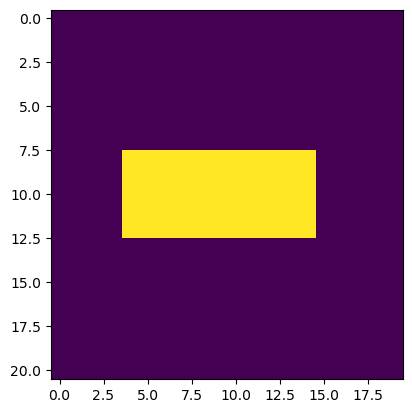

In [87]:
plt.imshow(kl2)

In [88]:
k1d = [50, kl2, 200]
k331d = [10, k33l2, 20]

In [89]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=icelltype, k=k1d, k33=k331d)

In [90]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps1...
  writing model ps1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package river...
    writing package canal...
    writing package oc...
    writing package npf...


In [91]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

### Summarize the effect on the groundwater flow pattern

In [92]:
hds1d = gwf.output.head().get_data()

In [93]:
spd1d = gwf.output.budget().get_data(text="DATA-SPDIS")[0]

In [94]:
qx1d, qy1d, qz1d = flopy.utils.postprocessing.get_specific_discharge(spd1d, gwf)

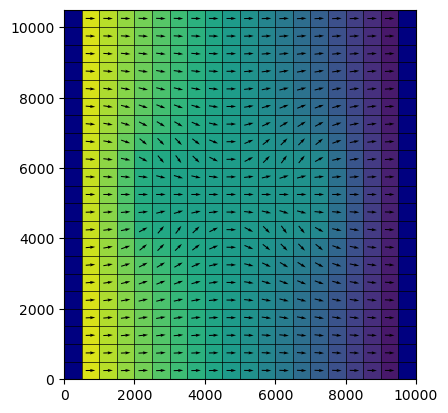

In [95]:
mm = flopy.plot.PlotMapView(model=gwf, )
cbv = mm.plot_array(hds1d)
q = mm.plot_vector(qx1d, qy1d, normalize=True)
mm.plot_bc("CHD")
mm.plot_bc("CHD")
mm.plot_grid(lw=0.5, color="black")

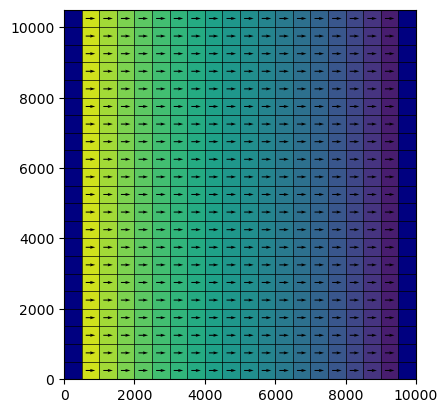

In [96]:
# PS1a results
mm = flopy.plot.PlotMapView(model=gwf, )
cbv = mm.plot_array(hds)
q = mm.plot_vector(spd["qx"], spd["qy"], normalize=True)
mm.plot_bc("CHD")
mm.plot_bc("CHD")
mm.plot_grid(lw=0.5, color="black")

## PS1E

Using idomain to make the hole in the silt.

In [97]:
sim = flopy.mf6.MFSimulation.load(sim_ws="PS1a")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading solution package ps1...


In [98]:
ws = pl.Path("PS1e")
sim.set_sim_path(ws)

In [99]:
gwf = sim.get_model()

In [100]:
idomainl2 = np.full((nrow, ncol), 1, dtype=int)
idomainl2[8:13, 4:15] = -1

In [101]:
botml1 = np.full((nrow, ncol), 220.)
botml1[8:13, 4:15] = 200.

In [102]:
idomain1e = [1, idomainl2, 1]
botm1e = [botml1, 200., 0]

In [103]:
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm1e, idomain=idomain1e)

In [104]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps1...
  writing model ps1...
    writing model name file...
    writing package ic...
    writing package npf...
    writing package river...
    writing package canal...
    writing package oc...
    writing package dis...


In [105]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

### Summarize the effect on the groundwater flow pattern

In [106]:
hds1e = gwf.output.head().get_data()

In [107]:
hds1e[0].min(), hds1e[0].max()

(np.float64(320.0), np.float64(330.0))

In [108]:
spd1e = gwf.output.budget().get_data(text="DATA-SPDIS")[0]

In [109]:
qx1e, qy1e, qz1e = flopy.utils.postprocessing.get_specific_discharge(spd1e, gwf)

In [110]:
levels = np.arange(320, 331, 2)

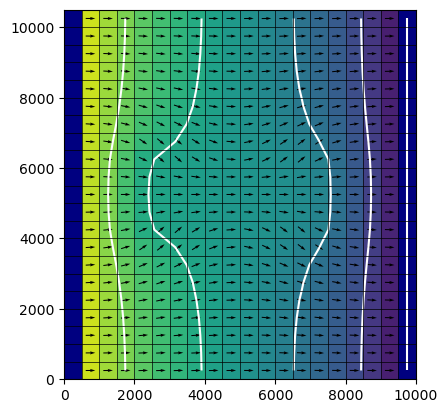

In [111]:
mm = flopy.plot.PlotMapView(model=gwf, )
cbv = mm.plot_array(hds1e)
mm.contour_array(hds1e, colors="white", levels=levels)
q = mm.plot_vector(qx1e, qy1e, normalize=True)
mm.plot_bc("CHD")
mm.plot_bc("CHD")
mm.plot_grid(lw=0.5, color="black")

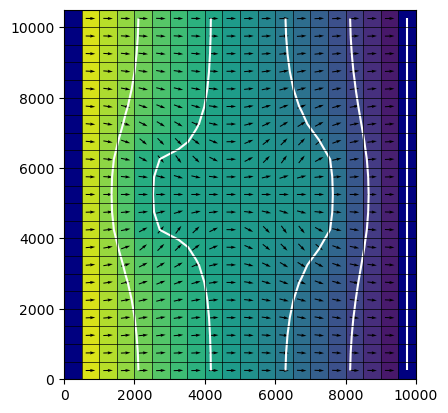

In [112]:
# PS1d results
mm = flopy.plot.PlotMapView(model=gwf, )
cbv = mm.plot_array(hds1d)
mm.contour_array(hds1d, colors="white", levels=levels)
q = mm.plot_vector(qx1d, qy1d, normalize=True)
mm.plot_bc("CHD")
mm.plot_bc("CHD")
mm.plot_grid(lw=0.5, color="black")